In [1]:
# Following https://github.com/dukelin95/vqa_pytorch to demo training results

In [2]:
# Set up

In [1]:
%matplotlib notebook
import torch
import numpy as np
import json

from tqdm import tqdm
from torch.autograd import Variable
import torchvision.transforms as transforms

import data
import config
import utils

import model_batchnormDP0
import model_batchnormDP05
import model_dropout0
import model_dropout05

import matplotlib.pyplot as plt
from scipy import ndimage

from demo.vqaTools.vqa import VQA
import random
import os
from PIL import Image
import demo_model
import pickle

def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = torch.nn.functional.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1), attention

def tens_to_img(image, ax=plt):
    image = image.cpu().detach().numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    return image

In [2]:
# load demo net
log = torch.load('RetinaNet_resnet101_50epoch.pth')
tokens = len(log['vocab']['question']) + 1
net = torch.nn.DataParallel(demo_model.Net(tokens)).cuda()
net.load_state_dict(log['weights'])

<All keys matched successfully>

In [26]:
# load inputs rather than preprocessing the whole dataset, we saved a small subset of the preprocessed inputs
v_s, q_s, a_s, q_lens = pickle.load(open("demo_inputs.p", "rb"))
# load the dictionary for answers
ans_voc = pickle.load(open("demo_ans_voc_dict.p", "rb"))

# hardcoded the answers because the dictionary for questions is too big
index_dict = {
    5: ['abstract_v002_test2015_000000030017.png', 'how many people are there?'],
    10: ['abstract_v002_test2015_000000030043.png', 'Is there a deer?'],
    15: ['COCO_val2014_000000240301.jpg', 'Are there any people in the image?']
}

Question: Are there any people in the image?
Network answer: no


<IPython.core.display.Javascript object>


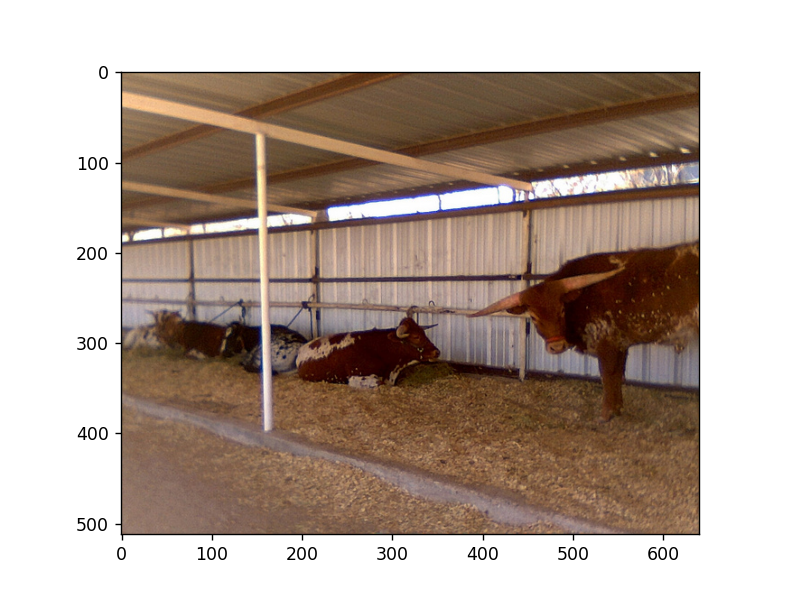

In [27]:
index = 15

# put to True if you have opencv2
view_glimpses = True
if view_glimpses:
    import cv2

imgFilename = index_dict[index][0]
question = index_dict[index][1]
I = Image.open('demo/' + imgFilename).convert('RGB')

if view_glimpses:
    # pass image through network
    transform = transforms.Compose([
                transforms.Scale(config.image_size),
                transforms.CenterCrop(config.image_size),
                transforms.ToTensor(),
            ])

    I_tens = transform(I) 

    q = q_s[index]
    v = v_s[index]
    a = a_s[index]
    q_len = q_lens[index]

    background = tens_to_img(I_tens)
    net.eval()
    hq = net.module.text(q, list(q_len.data))
    hv = v/(v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
    ha = net.module.attention(hv, hq)
    hv, attent = apply_attention(hv, ha)

    # get glimpse 1
    tens = attent[0, 0, 0, :]
    tens.shape[0]
    attent_img = tens.view(14,14).to('cpu').detach().numpy()
    up_img = ndimage.zoom(attent_img, 32, order=0)
    blur = ndimage.gaussian_filter(up_img, sigma=10)
    blur3 = 191*blur
    overlay = np.stack((blur3,blur3,blur3), axis=2)
    glimpse1 = cv2.addWeighted(background, 0.4,overlay,0.1,0)

    # get glimpse 2
    tens = attent[0, 1, 0, :]
    tens.shape[0]
    attent_img = tens.view(14,14).to('cpu').detach().numpy()
    up_img = ndimage.zoom(attent_img, 32, order=0)
    blur = ndimage.gaussian_filter(up_img, sigma=10)
    blur3 = 191*blur
    overlay = np.stack((blur3,blur3,blur3), axis=2)
    glimpse2 = cv2.addWeighted(background, 0.4,overlay,0.1,0)

# answers 
out = net(v, q, q_len)
_, answer = out.data.cpu().max(dim=1)
answ = (answer.view(-1))

print("Question: {0}".format(question))
print("Network answer: {0}".format(ans_voc[answ.item()]))
f = plt.figure()
plt.imshow(I)

<IPython.core.display.Javascript object>


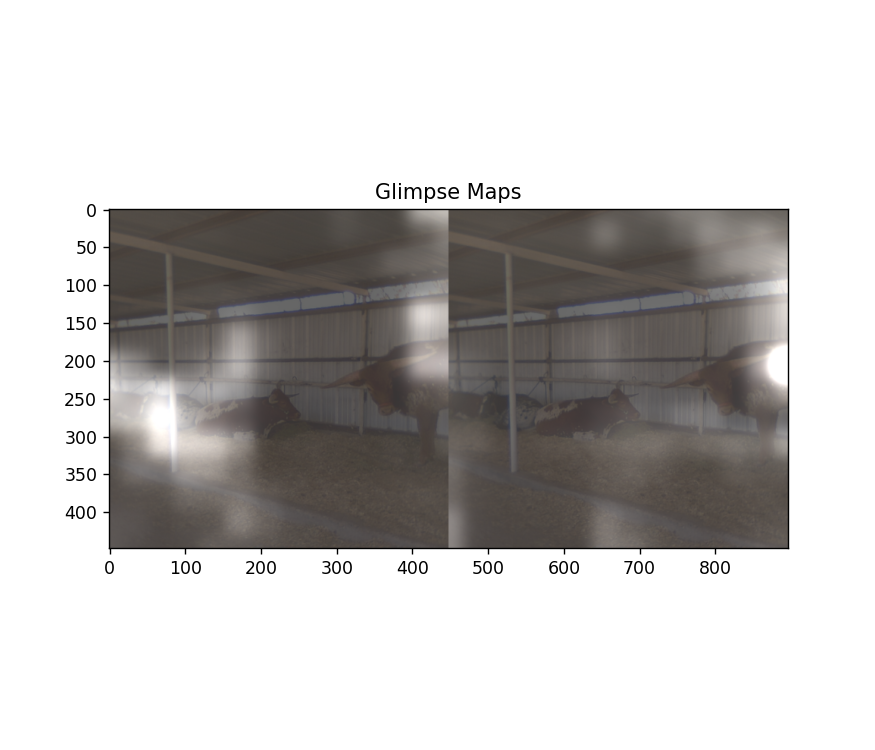

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [28]:
if view_glimpses:
    glimpses= np.concatenate((glimpse1, glimpse2), axis=1)
    fig_glimpses = plt.figure(figsize=(7,6))
    plt.title("Glimpse Maps")
    plt.imshow(glimpses)